Questions 
- What is the best solution for handling missing values
- There are some feature that I don't know what they are (Vxxx). What should we do with features we don't understand?

### Transaction Table *
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

### Identity Table *
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

In [127]:
import pandas as pd

dataset_path = '../datasets/fraud_datasets/'

# sample_submission_df = pd.read_csv(f'{dataset_path}sample_submission.csv')

train_transaction_df = pd.read_csv(f'{dataset_path}train_transaction.csv')
test_transaction_df = pd.read_csv(f'{dataset_path}test_transaction.csv')

train_id_df = pd.read_csv(f'{dataset_path}train_identity.csv')
test_id_df = pd.read_csv(f'{dataset_path}test_identity.csv')

After importing our raw datasets, they need to be merged by TransactionID's.

<b>(Note: throughout this notebook, it will be important to delete any dataframes that will not be used again as they take up space in memory and slow our machine down.)</b>

In [129]:
train = train_transaction_df.merge(train_id_df, on='TransactionID', how='left')
test = test_transaction_df.merge(test_id_df, on='TransactionID', how='left')

# Renaming columns for better description
names = {
    'addr1': 'billing zipcode',
    'addr2': 'country codes',
    'P_emaildomain': 'Purchaser_emaildom',
    'R_emaildomain': 'Retailer_email.dom'
}

train.rename(columns=names, inplace= True)
test.rename(columns=names, inplace= True)

del train_transaction_df, train_id_df, test_transaction_df, test_id_df

In [130]:
print(f'Training data has {train.shape[0]} rows and {train.shape[1]} columns')
print(f'Training data has {test.shape[0]} rows and {test.shape[1]} columns')

Training data has 590540 rows and 434 columns
Training data has 506691 rows and 433 columns


In [131]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [132]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Potentually will say something about removing Vxxx features but will wait to see what Teo says about feature we can't inturpt

## EDA
Visually exploring the dataset it important for familiarizing ourselves with it and trying to better understand the data before complex analysis is undertaken.

### Data
First, lets get an overview of the features and their data types.

<b>(Note: due to the large output the following script produces, the output can be found in the eda_output folder in under feature_overview.txt)</b>

In [135]:
import os

eda_output_path = 'eda_output/'
feat_over_file = 'feature_overview.txt'

if os.path.exists(f'{eda_output_path}{feat_over_file}'):
    os.remove(f'{eda_output_path}{feat_over_file}')

with open(f'{eda_output_path}{feat_over_file}', 'a') as overview_file:        
    for col, values in train.iteritems():
        overview_file.write(f'{col}: {values.nunique()} ({values.dtypes})\n')
        overview_file.write(str(values.unique()[:100]))
        overview_file.write('\n\n###########################################################\n\n')

When we examine the feature_overview.txt file, we notice that there are many continuous features and some categorical features.

### Missing Values

In [120]:
train_contains_na = train.isna().any().sum()
test_contains_na = test.isna().any().sum()

In [124]:
print(f'{train_contains_na} out of {len(train.columns)} columns contain missing values in the train data')
print(f'{test_contains_na} out of {len(test.columns)} columns contain missing values in the test data')

414 out of 434 columns contain missing values in the train data
385 out of 433 columns contain missing values in the test data


In [12]:
# Calculating percentage of missing values in each column
train_missing_values = train.isna().mean().round(2)
test_missing_values = test.isna().mean().round(2)

# Keeping only columns that contain more than 50% missing values
train_percent_missing_values = train_missing_values[train_missing_values.values > 0.5]
test_percent_missing_values = test_missing_values[test_missing_values.values > 0.5]

In [134]:
print(f'{len(train_percent_missing_values)} out of {len(train.columns)} columns in the train data contain more than 50% missing values')
print(f'{len(test_percent_missing_values)} out of {len(test.columns)} columns in the test data contain more than 50% missing values')

214 out of 434 columns in the train data contain more than 50% missing values
210 out of 433 columns in the test data contain more than 50% missing values


As we can see there are a large number of missing values in the data.

### Exploring the Features

### Target Feature: isFraud

In [14]:
t_fraud = train['isFraud'].copy()

In [126]:
print(f'isFraud contains {t_fraud.isna().any() * 1} missing values')

isFraud contains 0 missing values


In [111]:
# Plot values
fraud = t_fraud[t_fraud.values > 0.5].count()
not_fraud = t_fraud[t_fraud.values < 0.5].count()
total = t_fraud.count()
percent_fraud = [(not_fraud/total*100).round(3), (fraud/total*100).round(3)]

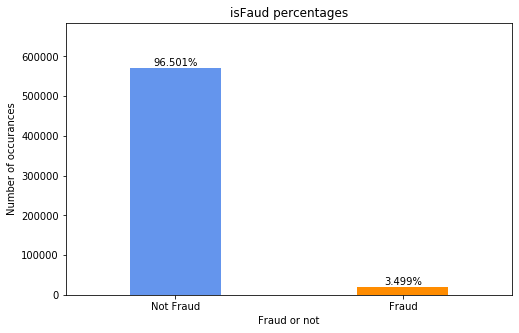

In [113]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=[8,5])
ax = f.add_subplot(1,1,1)
ax.title.set_text('isFaud percentages')
ax.margins(0.2)
ax.set_ylabel('Number of occurances')
ax.set_xlabel('Fraud or not')
ax.margins(0.2)
plot = ax.bar(["Not Fraud","Fraud"], [not_fraud, fraud], 0.40, color=['cornflowerblue', 'darkorange'])

# Add counts above the two bar graphs
i = 0
for rect in plot:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{percent_fraud[i]}%', ha='center', va='bottom')
    i += 1
    

A visual examination of the graph reveals an imbalance in the number of fraudulent transactions.

To correct this imbalanace, the use of a sampling method such as SMOTE or oversampling will be needed.

### Handling Missing Values
Due to the large number of NaN values our dataframes contain, it is critical that they are replaced with a meaningful placeholder.

In [4]:
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

Correctly construct and name our training and testing datasets, isolating target variable.

In [13]:
y_train = train['isFraud'].copy()
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test

NameError: name 'train' is not defined